In [1]:
# %%
import numpy as np
import sys
import os
import matplotlib.pyplot as plt
from scipy.optimize import minimize

In [2]:

# Добавляем путь к нашей песочнице если нужно
current_dir = os.getcwd()  # путь к notebooks
optimization_path = r"src"
if optimization_path not in sys.path:
    sys.path.append(optimization_path)

In [3]:
from spore_tree_config import SporeTreeConfig
from spore_tree import SporeTree
from pendulum import PendulumSystem
from visualize_spore_tree import visualize_spore_tree
from tree_evaluator import TreeEvaluator

In [4]:
pendulum = PendulumSystem(
    g=9.81,
    l=2.0, 
    m=1.0,
    damping=0.1,
    max_control=2.0
)

# Создание с дефолтными параметрами
config = SporeTreeConfig()
print("Дефолтная позиция:", config.initial_position)
print("Дефолтный вектор dt:", config.get_default_dt_vector())

# Создание с кастомными параметрами  
config_custom = SporeTreeConfig(
    initial_position=np.array([0.5, 0.1]),
    dt_base=0.002,
    figure_size=(10, 10),
    dt_grandchildren_factor=0.1  # 1/10
)
config_custom.validate()

Дефолтная позиция: [3.14159265 0.        ]
Дефолтный вектор dt: [1.e-03 1.e-03 1.e-03 1.e-03 5.e-05 5.e-05 5.e-05 5.e-05 5.e-05 5.e-05
 5.e-05 5.e-05]


True

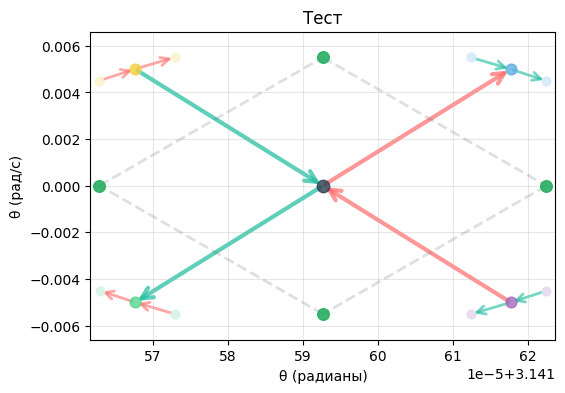

In [5]:
cfg = SporeTreeConfig(
    initial_position=np.array([np.pi, 0.0]),
    dt_base=0.01,
    dt_grandchildren_factor=0.1,
    figure_size=(6, 4)
)

tree = SporeTree(pendulum, cfg)
children = tree.create_children(show=False)
grandchildren = tree.create_grandchildren(show=False)
tree.sort_and_pair_grandchildren()
tree.calculate_mean_points()

# ──────────────────────────────────────────────────────────────────────
# 2. Кэш-оценщик на основе дерева
# ──────────────────────────────────────────────────────────────────────
visualize_spore_tree(tree, "Тест")

Optimization terminated successfully    (Exit mode 0)
            Current function value: -1.2533783803978654e-07
            Iterations: 1
            Function evaluations: 14
            Gradient evaluations: 1
pair distances: [1.2e-05 1.0e-03 1.2e-05 1.0e-03]
area: 1.2533783803978654e-07


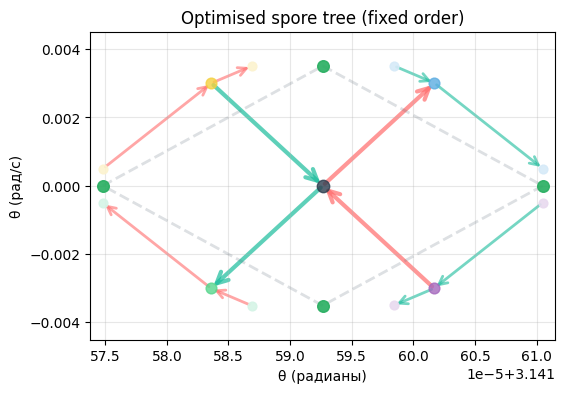

[0.00602029 0.00601109 0.00602029 0.00601109]
[0.00502013 0.00100744 0.00100744 0.00501334 0.00502013 0.00100744
 0.00100744 0.00501334]


In [12]:
bounds = [(0.001, 0.5)]*12  # дети / внуки
init_guess = cfg.get_default_dt_vector()


evaluator = TreeEvaluator(tree)

def objective(dt_all):
    return -evaluator.area(dt_all)          # maximize area → minimise (-area)

epsilon = 1e-3
constraints = [
    {
        'type': 'ineq',
        'fun': (lambda idx: lambda v: epsilon - evaluator.pair_distances(v)[idx])(i)
    }
    for i in range(4)
]

result = minimize(objective, init_guess, method='SLSQP',
                  bounds=bounds, constraints=constraints,
                  options={'maxiter': 400, 'disp': True, 'eps': 1e-3})

print("pair distances:", np.round(evaluator.pair_distances(result.x), 6))
print("area:", -result.fun)
visualize_spore_tree(tree, title="Optimised spore tree (fixed order)")
print(result.x[:4])
print(result.x[4:])
